In [956]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler

In [957]:
seed=2021
np.random.seed(seed)
sns.set_style("darkgrid")

In [958]:
data = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")

In [959]:
data.dropna(inplace = True)

In [960]:
train_data, test_data = train_test_split(data,test_size=0.2, random_state = seed)

# **Data explore**

In [961]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3927 entries, 4819 to 1203
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3927 non-null   int64  
 1   gender             3927 non-null   object 
 2   age                3927 non-null   float64
 3   hypertension       3927 non-null   int64  
 4   heart_disease      3927 non-null   int64  
 5   ever_married       3927 non-null   object 
 6   work_type          3927 non-null   object 
 7   Residence_type     3927 non-null   object 
 8   avg_glucose_level  3927 non-null   float64
 9   bmi                3927 non-null   float64
 10  smoking_status     3927 non-null   object 
 11  stroke             3927 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 398.8+ KB


In [962]:
train_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,3927.000000,3927.000000,3927.000000,3927.000000,3927.000000,3927.000000,3927.000000
mean,36962.415075,43.132844,0.093965,0.049656,105.392185,28.793379,0.043545
std,20955.848370,22.644014,0.291817,0.217261,44.595527,7.795899,0.204106
min,77.000000,0.080000,0.000000,0.000000,55.120000,11.300000,0.000000
25%,18378.000000,25.000000,0.000000,0.000000,77.025000,23.500000,0.000000
50%,37395.000000,45.000000,0.000000,0.000000,91.650000,28.000000,0.000000
75%,55154.500000,61.000000,0.000000,0.000000,113.820000,32.900000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


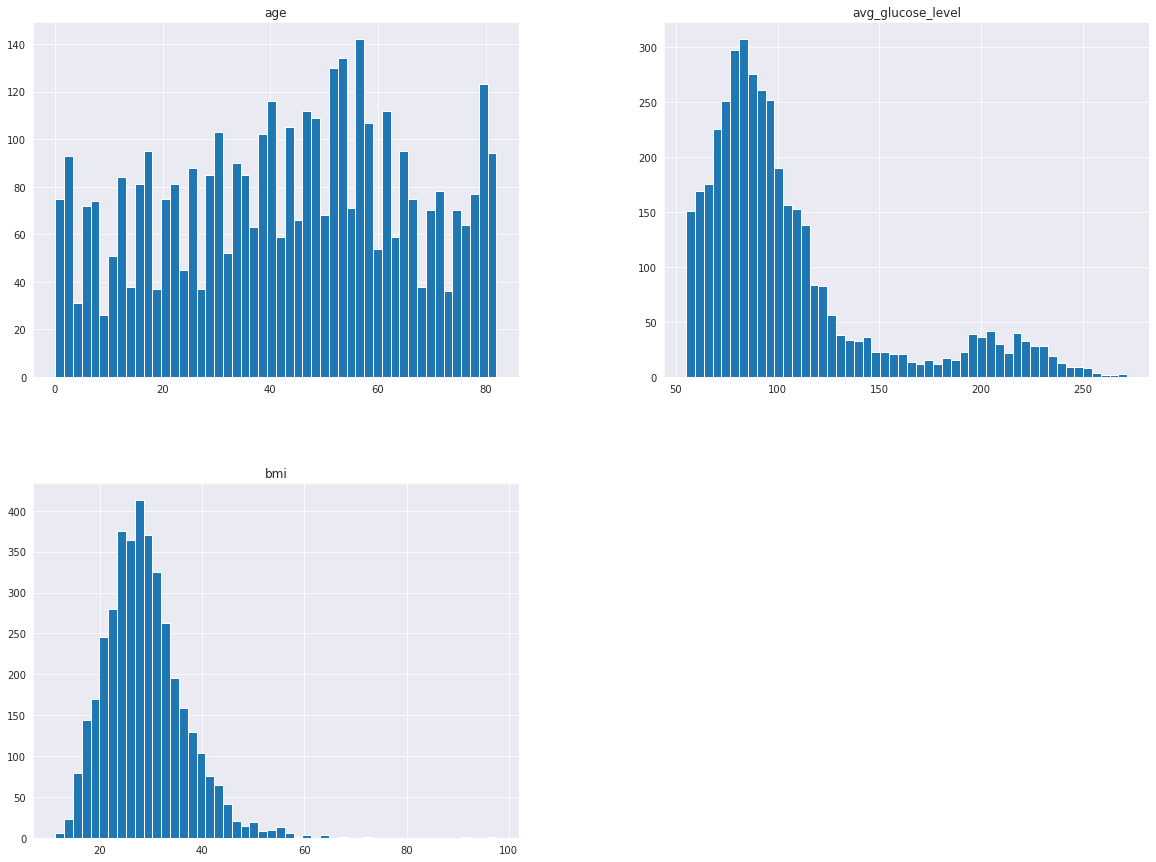

In [963]:
train_data[['age','avg_glucose_level','bmi']].hist(bins=50, figsize=(20,15))
plt.show()

Lets delete some outliers

In [964]:
train_data = train_data[train_data["bmi"] < train_data["bmi"].quantile(0.97)]
train_data = train_data[train_data["bmi"] > train_data["bmi"].quantile(0.01)]

train_data = train_data[train_data["avg_glucose_level"] < train_data["avg_glucose_level"].quantile(0.99)]

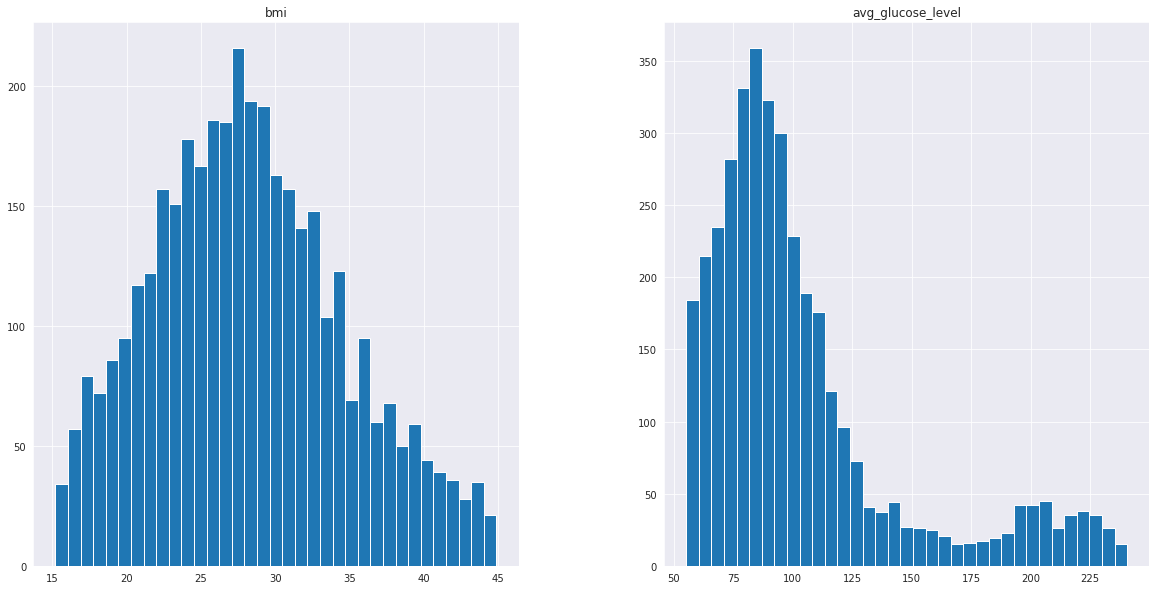

In [965]:
train_data[['bmi','avg_glucose_level']].hist(bins=35, figsize=(20,10))
plt.show()

Text(0.5, 0.98, 'Smoking distibution')

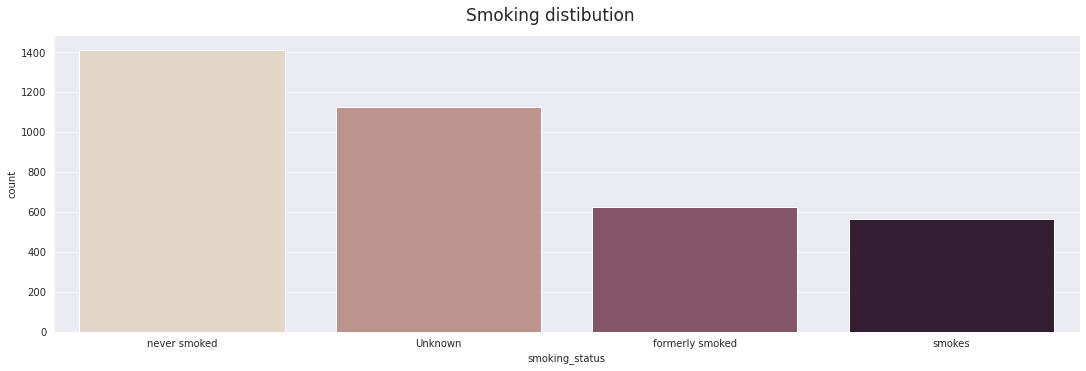

In [966]:
b1 = sns.catplot(x="smoking_status", kind="count", palette="ch:.25", data=train_data, aspect = 3, order = train_data['smoking_status'].value_counts().index)
plt.subplots_adjust(top=0.9)
b1.fig.suptitle('Smoking distibution', fontsize = 17)

Text(0.5, 0.98, 'Working distibution')

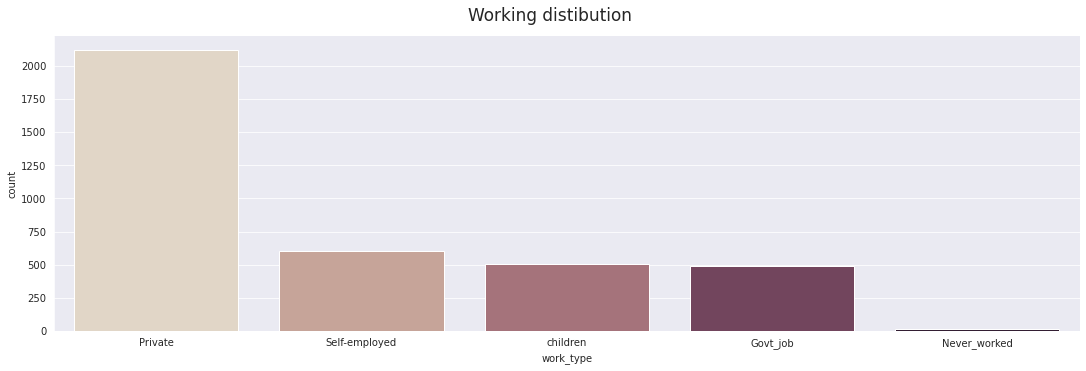

In [967]:
b1 = sns.catplot(x="work_type", kind="count", palette="ch:.25", data=train_data, aspect = 3, order = train_data['work_type'].value_counts().index)
plt.subplots_adjust(top=0.9)
b1.fig.suptitle('Working distibution', fontsize = 17)

Text(0.5, 1.0, 'CORRELATION BETWEEN INPUTS')

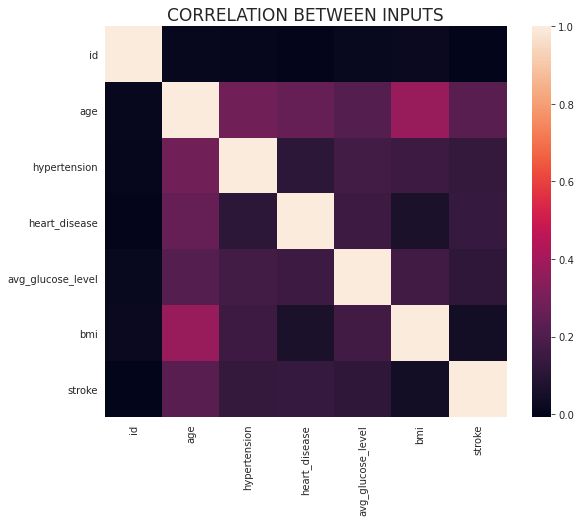

In [968]:
fig, ax = plt.subplots(figsize=(9,7))
b5 = sns.heatmap(train_data.corr(), ax=ax)
plt.subplots_adjust(top=0.9)
b5.set_title('CORRELATION BETWEEN INPUTS', fontsize = 17)

# Data preprocess

In [969]:
numerical_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

In [970]:
binary_pipeline = OrdinalEncoder()

In [971]:
categorical_pipeline = OneHotEncoder(handle_unknown='ignore')

In [972]:
#Check for possible values in each columns 
print(train_data.apply(lambda col: col.unique()))

id                   [48118, 15824, 841, 67350, 54579, 43090, 26727...
gender                                                  [Female, Male]
age                  [82.0, 67.0, 34.0, 64.0, 75.0, 62.0, 79.0, 14....
hypertension                                                    [0, 1]
heart_disease                                                   [0, 1]
ever_married                                                 [Yes, No]
work_type            [Self-employed, Private, Govt_job, children, N...
Residence_type                                          [Urban, Rural]
avg_glucose_level    [113.45, 81.68, 83.75, 78.85, 87.69, 74.32, 88...
bmi                  [30.3, 30.4, 37.0, 33.9, 27.5, 34.0, 22.9, 24....
smoking_status        [never smoked, formerly smoked, Unknown, smokes]
stroke                                                          [0, 1]
dtype: object


In [973]:
numerical_features = ["age", "avg_glucose_level", "bmi"]
binary_features = ["hypertension", "heart_disease", "ever_married", "Residence_type"]
categorical_features = ["gender", "work_type", "smoking_status"]

In [974]:
#For adding own feature, it didn't work well 
from sklearn.preprocessing import FunctionTransformer
def add_extra_features(X):
    diabetes_feature = [[1,0,0] if x > 200 else [0,1,0] if x < 140 else [0,0,1] for x in X["avg_glucose_level"]]
    return np.c_[diabetes_feature]


In [991]:
preprocess_pipeline = ColumnTransformer([
    #('attribs_adder', FunctionTransformer(add_extra_features, validate=False), train_data.columns),
    ("num", numerical_pipeline, numerical_features),
    ("bin", binary_pipeline, binary_features),
    ("cat", categorical_pipeline, categorical_features),
])

In [992]:
X = preprocess_pipeline.fit_transform(train_data)
y = train_data["stroke"]

In [994]:
X_test = preprocess_pipeline.transform(test_data)
y_test = test_data["stroke"]

# **Random Forest**

In [995]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

In [1016]:
rf = RandomForestClassifier(max_depth=8,criterion='entropy',class_weight='balanced_subsample',random_state=seed)
rf.fit(X, y)
predicted_y = rf.predict(X_test)
print(confusion_matrix(predicted_y, y_test))
print(classification_report(predicted_y, y_test))

[[851  16]
 [ 93  22]]
-----
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       867
           1       0.58      0.19      0.29       115

    accuracy                           0.89       982
   macro avg       0.74      0.59      0.61       982
weighted avg       0.86      0.89      0.86       982

